<a href="https://colab.research.google.com/github/bvchand/Diabetes-detection-in-ICU-patients/blob/main/diabetes_models_stratified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sqlite3
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, StandardScaler
from fancyimpute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd '/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021'

/content/drive/Shareddrives/CMPE-255_Project/widsdatathon2021


In [4]:
#Load all pickled data
KNN_imputed_trainX = pickle.load(open("KNN_imputed_trainX.pkl", "rb"))
KNN_imputed_testX_df = pickle.load(open("KNN_imputed_testX_df.pkl", "rb"))
train_y = pickle.load(open("diabetes_train_y.pkl", "rb"))
test_y = pickle.load(open("diabetes_test_y.pkl", "rb"))

pca_95per_train = pickle.load(open("pca_95per_train.pkl", "rb"))
pca_97per_train = pickle.load(open("pca_97per_train.pkl", "rb"))
pca_99per_train = pickle.load(open("pca_99per_train.pkl", "rb"))

pca_95per_test = pickle.load(open("pca_95per_test.pkl", "rb"))
pca_97per_test = pickle.load(open("pca_97per_test.pkl", "rb"))
pca_99per_test = pickle.load(open("pca_99per_test.pkl", "rb"))

In [5]:
train_y[[5903, 68265]]

5903     0
68265    0
Name: diabetes_mellitus, dtype: int64

In [6]:
KNN_imputed_trainX.index = np.arange(104125)
train_y.index = np.arange(104125)
KNN_imputed_trainX

,bmi,ethnicity,gender,height,hospital_admit_source,icu_admit_source,pre_icu_los_days,weight,apache_3j_diagnosis,apache_post_operative,arf_apache,bun_apache,creatinine_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,resprate_apache,sodium_apache,temp_apache,ventilated_apache,wbc_apache,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,...,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,age
0,28.734672,0.0,1.0,173.00,3.0,0.0,0.072917,86.00,403.0,0.0,0.0,18.333333,0.927000,4.000000,6.0,0.0,5.0,151.483333,55.0,36.133333,0.0,140.0,8.0,137.333333,36.6,0.0,9.123000,119.0,56.0,119.0,56.0,83.0,56.0,140.0,80.0,140.0,80.0,22.0,8.0,99.0,...,80.000000,75.000000,64.0,124.000000,96.000000,124.000000,96.000000,18.000000,14.000000,98.0,96.000000,173.000000,140.000000,173.000000,140.000000,36.800000,36.800000,19.866667,18.466667,8.653333,8.550000,1.104667,1.064333,168.166667,115.9,25.766667,24.033333,12.293333,12.146667,36.803333,36.416667,213.466667,210.000000,4.073333,3.756667,137.933333,137.333333,9.983000,9.591333,60.000000
1,30.295175,5.0,1.0,167.70,8.0,2.0,3.738889,85.20,1207.0,1.0,0.0,15.000000,0.960000,3.866667,5.9,1.0,4.3,124.000000,102.0,31.500000,0.0,160.0,36.0,137.000000,36.6,1.0,9.800000,100.0,36.0,100.0,36.0,102.0,72.0,114.0,59.0,114.0,59.0,28.0,0.0,100.0,...,49.000000,98.000000,84.0,102.000000,71.000000,102.000000,71.000000,23.000000,14.000000,100.0,95.000000,158.000000,108.000000,158.000000,108.000000,36.600000,36.600000,15.000000,15.000000,8.300000,8.300000,0.960000,0.960000,124.000000,124.0,21.000000,21.000000,10.800000,10.800000,31.500000,31.500000,123.000000,123.000000,4.400000,4.400000,137.000000,137.000000,9.800000,9.800000,73.000000
2,44.123628,2.0,1.0,172.70,3.0,0.0,0.109722,131.60,301.0,0.0,0.0,10.000000,1.100000,1.000000,4.0,0.0,2.0,140.000000,109.0,38.600000,0.0,47.0,48.0,136.000000,36.3,0.0,8.600000,74.0,26.0,74.0,26.0,100.0,60.0,108.0,60.0,108.0,60.0,48.0,14.0,99.0,...,70.000000,76.000000,76.0,106.000000,106.000000,106.000000,106.000000,20.000000,18.000000,96.0,96.000000,161.000000,154.000000,161.000000,154.000000,36.300000,36.300000,10.000000,10.000000,8.400000,8.400000,1.100000,1.100000,140.000000,140.0,27.000000,27.000000,13.700000,13.700000,38.600000,38.600000,122.000000,122.000000,3.900000,3.900000,136.000000,136.000000,8.600000,8.600000,70.000000
3,18.563897,2.0,1.0,195.59,3.0,0.0,0.340972,75.00,110.0,0.0,0.0,62.000000,1.820000,2.000000,5.0,0.0,2.0,157.000000,122.0,31.800000,0.0,156.0,27.0,137.000000,36.2,0.0,6.000000,152.0,58.0,152.0,58.0,122.0,86.0,156.0,70.0,156.0,70.0,27.0,13.0,100.0,...,79.000000,104.000000,102.0,118.000000,96.000000,118.000000,96.000000,21.000000,17.000000,98.0,92.000000,159.000000,147.000000,159.000000,147.000000,37.400000,37.400000,62.000000,54.000000,7.800000,6.900000,1.820000,1.670000,157.000000,109.0,22.000000,19.000000,10.300000,10.300000,31.800000,31.800000,76.000000,76.000000,4.800000,3.600000,141.000000,137.000000,6.000000,6.000000,68.000000
4,22.500000,0.0,0.0,160.00,3.0,0.0,0.001389,57.60,107.0,0.0,0.0,41.000000,1.600000,4.000000,6.0,0.0,5.0,90.000000,98.0,36.000000,0.0,50.0,12.0,135.000000,36.8,1.0,13.470000,99.0,38.0,99.0,38.0,98.0,67.0,107

In [7]:
train_y

0         1
1         0
2         0
3         0
4         0
         ..
104120    0
104121    1
104122    0
104123    1
104124    0
Name: diabetes_mellitus, Length: 104125, dtype: int64

# Logistic regression

In [8]:
#standardize data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(KNN_imputed_trainX)
scaled_test_df = scaler.fit_transform(KNN_imputed_testX_df)

#### stratefied k fold LR

In [9]:
def stratKfold(clf_strat):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    lst_accu_stratified = []

    # clf_strat = LogisticRegression(random_state=0, max_iter=200)

    for train_index, test_index in skf.split(KNN_imputed_trainX, train_y):
        x_train_fold, x_val_fold = scaled_df[train_index], scaled_df[test_index]
        y_train_fold, y_val_fold = train_y[train_index.tolist()], train_y[test_index.tolist()]
        %time clf_strat.fit(x_train_fold, y_train_fold)
        lst_accu_stratified.append(clf_strat.score(x_val_fold, y_val_fold))
    
    # Print the output.
    print('List of possible validation scores:', lst_accu_stratified)
    print('\nMaximum validation score that can be obtained from this model is:',
        max(lst_accu_stratified)*100, '%')
    print('\nMinimum validation score:',
        min(lst_accu_stratified)*100, '%')
    print('\nOverall validation score:',
        mean(lst_accu_stratified)*100, '%')
    print('\nStandard Deviation is:', stdev(lst_accu_stratified))

    return clf_strat

In [ ]:
clf_strat_lr = LogisticRegression(random_state=0, max_iter=200)
clf_strat_lr = stratKfold(clf_strat_lr)

CPU times: user 4.37 s, sys: 1.15 s, total: 5.52 s
Wall time: 2.86 s
CPU times: user 5.63 s, sys: 1.43 s, total: 7.07 s
Wall time: 3.64 s
CPU times: user 5.95 s, sys: 1.48 s, total: 7.42 s
Wall time: 3.81 s
CPU times: user 6.08 s, sys: 1.51 s, total: 7.59 s
Wall time: 3.88 s
CPU times: user 5.08 s, sys: 1.31 s, total: 6.38 s
Wall time: 3.28 s
List of possible validation scores: [0.7838175270108043, 0.7838175270108043, 0.7838655462184874, 0.7838655462184874, 0.7838655462184874]

Maximum validation score that can be obtained from this model is: 78.38655462184873 %

Minimum validation score: 78.38175270108043 %

Overall validation score: 78.38463385354142 %

Standard Deviation is: 2.6301203241530598e-05


In [ ]:
LR_y_pred_strat = clf_strat.predict(scaled_test_df)
test_score = clf_strat.score(scaled_test_df,test_y)
print(test_score)

0.7816533497234174


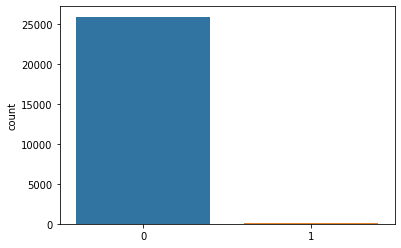

In [ ]:
sns.countplot(LR_y_pred_strat)

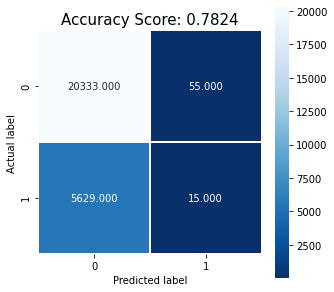

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, LR_y_pred_strat)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(test_score)
plt.title(all_sample_title, size = 15);

#### normal LR

In [ ]:
# Apply logistic regression
clf = LogisticRegression(random_state=0, max_iter=200).fit(scaled_df, train_y)
pred = clf.predict(scaled_test_df)
train_score = clf.score(scaled_df,train_y)
test_score = clf.score(scaled_test_df,test_y)

print(train_score)
print(test_score)

0.7838463385354142
0.7824216349108789


In [ ]:
pred

array([0, 0, 0, ..., 0, 0, 0])

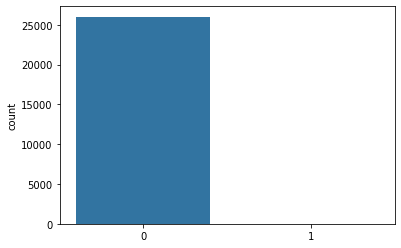

In [ ]:
sns.countplot(pred)

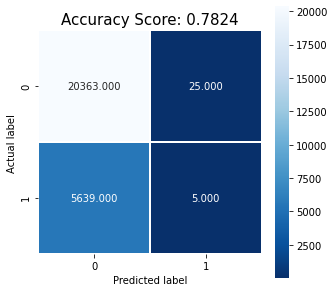

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0:.4f}'.format(test_score)
plt.title(all_sample_title, size = 15);

#SVM

In [ ]:
KNN_imputed_trainX = KNN_imputed_trainX[KNN_imputed_testX_df.columns]
KNN_imputed_testX = KNN_imputed_testX_df

In [ ]:
#standardize the data for SVM
scaler = StandardScaler()
KNN_imputed_trainX_scaled = scaler.fit_transform(KNN_imputed_trainX)
KNN_imputed_testX_scaled = scaler.transform(KNN_imputed_testX)

KNN_imputed_trainX_scaled_df = pd.DataFrame(KNN_imputed_trainX_scaled, columns=KNN_imputed_trainX.columns, index=KNN_imputed_trainX.index)
print(KNN_imputed_trainX_scaled_df.info)

KNN_imputed_testX_scaled_df = pd.DataFrame(KNN_imputed_testX_scaled, columns=KNN_imputed_testX.columns, index=KNN_imputed_testX.index)
print(KNN_imputed_testX_scaled_df.info)

<bound method DataFrame.info of              age       bmi  ethnicity  ...  d1_sodium_min  d1_wbc_max  d1_wbc_min
115201 -0.119229 -0.042240  -1.884170  ...      -0.078927   -0.392034   -0.300572
5903    0.668470  0.150551   2.787024  ...      -0.150119   -0.420961   -0.262781
68265   0.486693  1.858973  -0.015693  ...      -0.363694   -0.610651   -0.480111
109489  0.365509 -1.298778  -0.015693  ...      -0.150119   -1.021645   -0.950994
14762  -0.664559 -0.812496  -1.884170  ...      -0.150119   -0.015131    0.066886
...          ...       ...        ...  ...            ...         ...         ...
128106 -2.542917 -0.376282  -0.015693  ...      -4.421627   -0.531614   -0.389557
103694  0.001659 -0.887381  -0.015693  ...       1.131334   -0.721303   -0.606887
860     1.516761  0.110271  -0.015693  ...      -0.271145   -0.193070   -0.093746
15795   0.062548  0.267526  -0.015693  ...       1.772060    3.497712    4.226904
121958  0.304917 -0.982155   0.918546  ...       0.277032   -1.132

#### SVM classifier with C=0.1 and a linear kernel



In [ ]:
svm = SVC(C=0.1, kernel='linear', random_state=0)
# %time svm.fit(KNN_imputed_trainX_scaled_df, train_y)

In [ ]:
# pickle.dump(svm, open("svm_classifier.pkl", "wb"))
svm = pickle.load(open("svm_classifier.pkl", "rb"))

In [ ]:
diabetes_y_pred = svm.predict(KNN_imputed_testX_scaled_df)

In [ ]:
svm_test_accuracy = accuracy_score(test_y, diabetes_y_pred)

In [ ]:
print("Test accuracy for the SVM classifier with C=0.1 and a linear kernel: ",svm_test_accuracy)

Test accuracy for the SVM classifier with C=0.1 and a linear kernel:  0.7831899200983405


#### SVM classifier with C=1 and a linear kernel



In [ ]:
svm1 = SVC(C=1, kernel='linear', random_state=0)
%time svm1.fit(KNN_imputed_trainX_scaled_df, train_y)

In [ ]:
#pickle.dump(svm1, open("svm_classifier1.pkl", "wb"))
svm1 = pickle.load(open("svm_classifier1.pkl", "rb"))

In [ ]:
diabetes_y_pred_svm1 = svm1.predict(KNN_imputed_testX_scaled_df)

In [ ]:
pickle.dump(diabetes_y_pred_svm1, open("diabetes_y_pred_svm1.pkl", "wb"))
svm_test_accuracy1 = accuracy_score(test_y, diabetes_y_pred_svm1)

In [ ]:
print("Test accuracy for the SVM classifier with C=1 and a linear kernel: ",svm_test_accuracy1)

Test accuracy for the SVM classifier with C=1 and a linear kernel:  0.7831899200983405


# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import accuracy_score
RF_Cl_strat=RandomForestClassifier(n_estimators=200)
RF_Cl_stratr = stratKfold(RF_Cl_strat)
# start = time.time()
# # RF_Cl.fit(scaled_df,train_y) #training
# end = time.time()
# print("Time taken to train data with RFC in seconds :",end-start)

CPU times: user 2min 48s, sys: 578 ms, total: 2min 49s
Wall time: 2min 49s
CPU times: user 2min 43s, sys: 771 ms, total: 2min 44s
Wall time: 2min 44s
CPU times: user 2min 44s, sys: 753 ms, total: 2min 45s
Wall time: 2min 45s
CPU times: user 2min 51s, sys: 715 ms, total: 2min 52s
Wall time: 2min 53s
CPU times: user 2min 45s, sys: 554 ms, total: 2min 45s
Wall time: 2min 45s
List of possible validation scores: [0.7837695078031213, 0.7838655462184874, 0.7838655462184874, 0.7838175270108043, 0.7838655462184874]

Maximum validation score that can be obtained from this model is: 78.38655462184873 %

Minimum validation score: 78.37695078031213 %

Overall validation score: 78.38367346938774 %

Standard Deviation is: 4.2949685041989916e-05


In [11]:
y_pred = RF_Cl_stratr.predict(scaled_test_df)
test_score = RF_Cl_stratr.score(scaled_test_df,test_y)
print(test_score)

0.7821527350952674


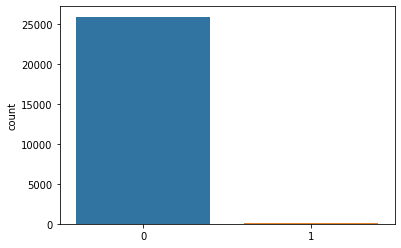

In [12]:
sns.countplot(y_pred)

In [13]:
print(RF_Cl_stratr.predict_proba(scaled_test_df))

[[0.775 0.225]
 [0.62  0.38 ]
 [0.555 0.445]
 ...
 [0.675 0.325]
 [0.645 0.355]
 [0.58  0.42 ]]


# XGB

In [ ]:
# data_dmatrix = xgb.DMatrix(data=KNN_imputed_trainX,label=train_y)
# data_test = xgb.DMatrix(data=KNN_imputed_testX_df,label=test_y)

In [14]:
xg_cl_strat = xgb.XGBClassifier(learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 100)
xg_cl_strat = stratKfold(xg_cl_strat)

CPU times: user 34.7 s, sys: 335 ms, total: 35 s
Wall time: 35.1 s
CPU times: user 34.9 s, sys: 233 ms, total: 35.1 s
Wall time: 35.1 s
CPU times: user 35.3 s, sys: 47 ms, total: 35.4 s
Wall time: 35.4 s
CPU times: user 35.2 s, sys: 55 ms, total: 35.3 s
Wall time: 35.3 s
CPU times: user 35.5 s, sys: 54.4 ms, total: 35.5 s
Wall time: 35.6 s
List of possible validation scores: [0.7837695078031213, 0.7837214885954382, 0.7838175270108043, 0.7838175270108043, 0.7838655462184874]

Maximum validation score that can be obtained from this model is: 78.38655462184873 %

Minimum validation score: 78.37214885954383 %

Overall validation score: 78.37983193277311 %

Standard Deviation is: 5.4750320532942686e-05


In [15]:
y_pred = xg_cl_strat.predict(scaled_test_df)
test_score = xg_cl_strat.score(scaled_test_df,test_y)
print(test_score)

0.7831130915795943


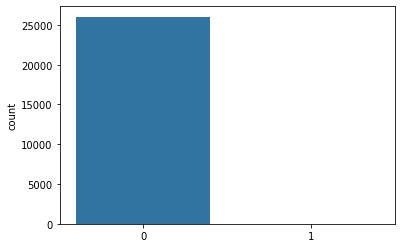

In [16]:
sns.countplot(y_pred)

In [17]:
print(xg_cl_strat.predict_proba(scaled_test_df))

[[0.86458224 0.13541774]
 [0.77518976 0.22481021]
 [0.8030861  0.19691391]
 ...
 [0.83764976 0.16235024]
 [0.7403462  0.25965378]
 [0.79056346 0.20943655]]


# Light GBM

In [ ]:
def evaluate_macroF1_lgb(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True)

In [ ]:
clf = lgb.LGBMClassifier(n_estimators=100)
%time clf.fit(KNN_imputed_trainX, train_y, eval_metric=evaluate_macroF1_lgb)

CPU times: user 10.2 s, sys: 46.8 ms, total: 10.2 s
Wall time: 5.44 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb_y_train_pred=clf.predict(KNN_imputed_trainX)
print("Train accuracy = {}".format(accuracy_score(train_y,lgb_y_train_pred)))

Train accuracy = 0.7843649459783913


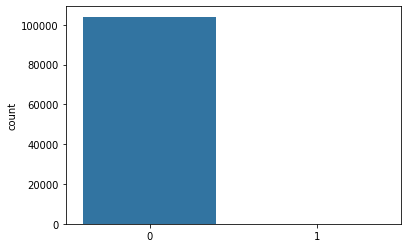

In [ ]:
sns.countplot(lgb_y_train_pred)

In [ ]:
# predict the results
lgb_y_pred=clf.predict(KNN_imputed_testX)

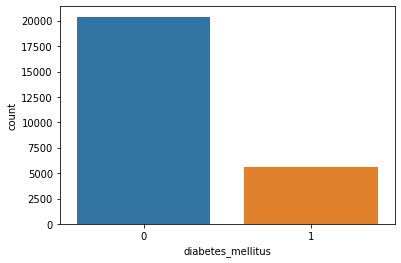

In [ ]:
sns.countplot(test_y)

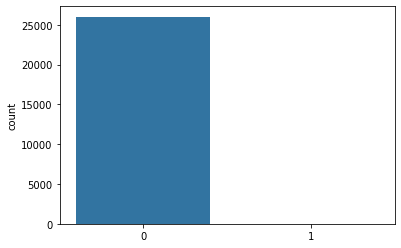

In [ ]:
sns.countplot(lgb_y_pred)

In [ ]:
print(classification_report(test_y, lgb_y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     20388
           1       0.14      0.00      0.00      5644

    accuracy                           0.78     26032
   macro avg       0.46      0.50      0.44     26032
weighted avg       0.64      0.78      0.69     26032



In [ ]:
lgb_accuracy=accuracy_score(lgb_y_pred, test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_accuracy))

LightGBM Model accuracy score: 0.7830


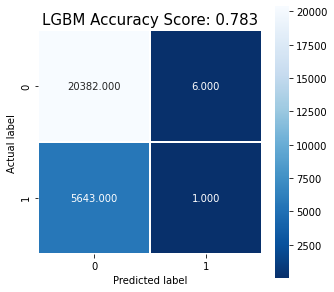

In [ ]:
#show confusion matrix
cm = confusion_matrix(test_y, lgb_y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'LGBM Accuracy Score: {0:.3f}'.format(lgb_accuracy)
plt.title(all_sample_title, size = 15);

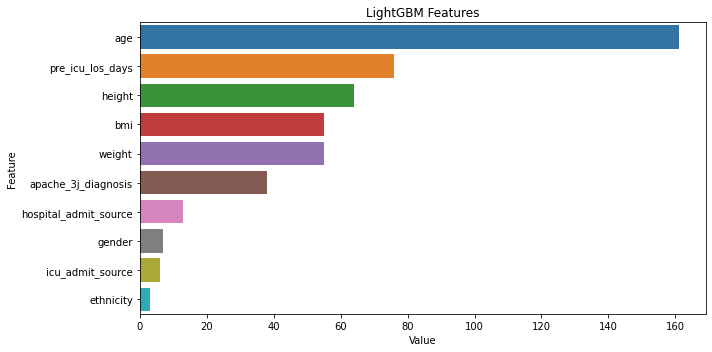

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_[:10],KNN_imputed_trainX.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

### Light GBM on the principal componenets

In [ ]:
lgbm_pca = lgb.LGBMClassifier(n_estimators=100)
%time lgbm_pca.fit(pca_97per_train, train_y)

CPU times: user 7.68 s, sys: 34.4 ms, total: 7.72 s
Wall time: 4.16 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
# predict the results
lgb_pca_y_pred=lgbm_pca.predict(pca_97per_test)

In [ ]:
lgb_pca_accuracy=accuracy_score(lgb_pca_y_pred, test_y)
print('LightGBM Model accuracy score: {0:0.4f}'.format(lgb_pca_accuracy))

LightGBM Model accuracy score: 0.7810


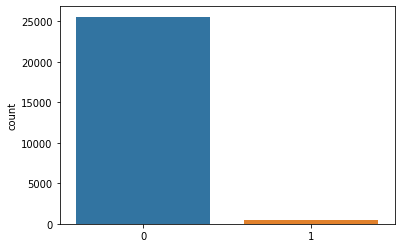

In [ ]:
sns.countplot(lgb_pca_y_pred)